In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb

from sklearn.metrics import precision_recall_curve

from yellowbrick.cluster import KElbowVisualizer

%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = [12,10]
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data and see the race value counts
df = pd.read_csv("CombinedWaistDataWithCoordinates with weight.csv")
df_Front = pd.read_csv("CurveCoefficients.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
df_Front.drop('Unnamed: 0', axis=1, inplace=True)
print(df["Race"].value_counts());

White          397
AfricanAmer     66
Asian           56
Other           15
Hispanic         6
Name: Race, dtype: int64


In [3]:
# Merge curve coefficient into the original data through subject ID
df = pd.merge(df, df_Front, on = "Subject",  left_index=True, right_index=True, how='inner')
df.isna().sum();
df = df.dropna();
df.reset_index(drop = True, inplace = True)

In [4]:
cols_x = [col for col in df.columns if col.endswith('_x')]
df = df.loc[:,~df.columns.isin(cols_x)]
df.columns

Index(['Subject', 'weight', 'Curve_Coordinates', 'Race_y', 'BMI_y', 'Height_y',
       'Max_Hip_y', 'Anterior_posterior_Length_y', 'Depth_y',
       'Crotch_curve_length_at_back_waist_y', 'Front_Crotch_y',
       'Back_Crotch_y', 'Curve_Coord_Front', 'Curve_Coord_Back',
       'Coef_Front_2_3', 'intercept_Front_2_3', 'Coef_Back_2_3',
       'intercept_Back_2_3', 'Coef_Front_3_3', 'intercept_Front_3_3',
       'Coef_Back_3_3', 'intercept_Back_3_3', 'Coef_Front_2_4',
       'intercept_Front_2_4', 'Coef_Back_2_4', 'intercept_Back_2_4'],
      dtype='object')

In [5]:
# Create front and back curve coefficient columns.
df["f_coef_1"] = 1
df["f_coef_2"] = 1
df["f_coef_3"] = 1
df["f_coef_4"] = 1
df["b_coef_1"] = 1
df["b_coef_2"] = 1
df["b_coef_3"] = 1
df["b_coef_4"] = 1

In [6]:
# Add front curve coeffcient into the original data set
df["Coef_Front_2_3"];
for x in range(len(df)):
    df["f_coef_1"][x] = df["Coef_Front_2_3"][x].strip("[]").split(",")[0]
    df["f_coef_2"][x] = df["Coef_Front_2_3"][x].strip("[]").split(",")[1]
    df["f_coef_3"][x] = df["Coef_Front_2_3"][x].strip("[]").split(",")[2]
    df["f_coef_4"][x] = df["Coef_Front_2_3"][x].strip("[]").split(",")[3]

df["f_coef_1"] = df["f_coef_1"].astype("float64")
df["f_coef_2"] = df["f_coef_2"].astype("float64")
df["f_coef_3"] = df["f_coef_3"].astype("float64")
df["f_coef_4"] = df["f_coef_4"].astype("float64")
    
df["f_coef_1"] = df["f_coef_1"].apply(lambda x: format(x, '.3f'))
df["f_coef_2"] = df["f_coef_2"].apply(lambda x: format(x, '.3f'))
df["f_coef_3"] = df["f_coef_3"].apply(lambda x: format(x, '.3f'))
df["f_coef_4"] = df["f_coef_4"].apply(lambda x: format(x, '.3f'))

In [7]:
# Add back curve coeffcient into the original data set
df["Coef_Back_2_3"];
for x in range(len(df)):
    df["b_coef_1"][x] = df["Coef_Back_2_3"][x].strip("[]").split(",")[0]
    df["b_coef_2"][x] = df["Coef_Back_2_3"][x].strip("[]").split(",")[1]
    df["b_coef_3"][x] = df["Coef_Back_2_3"][x].strip("[]").split(",")[2]
    df["b_coef_4"][x] = df["Coef_Back_2_3"][x].strip("[]").split(",")[3]

df["b_coef_1"] = df["b_coef_1"].astype("float64")
df["b_coef_2"] = df["b_coef_2"].astype("float64")
df["b_coef_3"] = df["b_coef_3"].astype("float64")
df["b_coef_4"] = df["b_coef_4"].astype("float64")
    
df["b_coef_1"] = df["b_coef_1"].apply(lambda x: format(x, '.3f'))
df["b_coef_2"] = df["b_coef_2"].apply(lambda x: format(x, '.3f'))
df["b_coef_3"] = df["b_coef_3"].apply(lambda x: format(x, '.3f'))
df["b_coef_4"] = df["b_coef_4"].apply(lambda x: format(x, '.3f'))

In [8]:
# Take out the columns we need
df = df.iloc[:,[0,1,3,4,5,6,7,8,9,10,11,26,27,28,29,30,31,32,33]]
df;

In [9]:
# Convert datatype to float
df["Height_y"] = df["Height_y"].astype("float64")
df["Max_Hip_y"] = df["Max_Hip_y"].astype("float64")
df["f_coef_1"] = df["f_coef_1"].astype("float64")
df["f_coef_2"] = df["f_coef_2"].astype("float64")
df["f_coef_3"] = df["f_coef_3"].astype("float64")
df["f_coef_4"] = df["f_coef_4"].astype("float64")
df["b_coef_1"] = df["b_coef_1"].astype("float64")
df["b_coef_2"] = df["b_coef_2"].astype("float64")
df["b_coef_3"] = df["b_coef_3"].astype("float64")
df["b_coef_4"] = df["b_coef_4"].astype("float64")

In [10]:
df.rename(columns = {"BMI_y":"BMI","Height_y":"Height","Max_Hip_y":"Max_Hip","Anterior_posterior_Length_y":"Anterior_posterior_Length",
                     "Depth_y":"Depth","Crotch_curve_length_at_back_waist_y":"Crotch_curve_length_at_back_waist","Front_Crotch_y":"Front_Crotch",
                     "Back_Crotch_y":"Back_Crotch","Race_y":"Race"}, inplace = True)

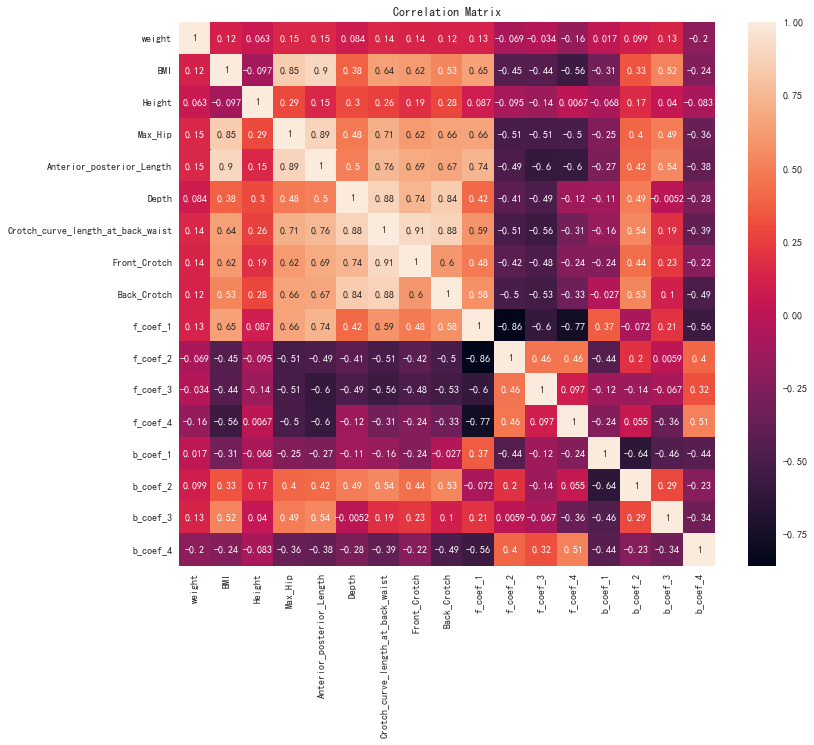

In [11]:
# Correlation heatmap
corr = df.iloc[:,[1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]].corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns, yticklabels=corr.columns)
plt.title("Correlation Matrix");

In [12]:
# Only look at the White and African American people's data
df = df[(df["Race"]=="White") | (df["Race"]=="AfricanAmer")]
df.reset_index(inplace = True, drop = True)
df;

In [13]:
df2 = df.iloc[:,[1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]
df2

,weight,BMI,Height,Max_Hip,Anterior_posterior_Length,Depth,Crotch_curve_length_at_back_waist,Front_Crotch,Back_Crotch,f_coef_1,f_coef_2,f_coef_3,f_coef_4,b_coef_1,b_coef_2,b_coef_3,b_coef_4
0,76.19,21.400000,1601.0,934.0,254.2900,245.0120,662.811,311.565,351.246,137.750,-37.204,-44.023,-56.523,-120.081,107.819,52.613,-40.351
1,74.06,26.000000,1685.0,1097.0,281.7800,234.3100,661.394,307.836,353.558,180.631,-68.187,-57.729,-54.715,-106.661,82.001,55.482,-30.822
2,85.92,32.900000,1644.0,1231.0,348.9300,249.7300,737.270,343.401,393.869,261.676,-80.415,-82.553,-98.708,-102.555,85.451,45.998,-28.894
3,94.30,23.700000,1603.0,1020.0,277.1100,313.6700,811.027,390.940,420.087,192.094,-76.409,-52.685,-63.000,-119.169,115.620,33.099,-29.549
4,78.04,24.100000,1554.0,1034.0,265.9500,267.7900,703.322,336.187,367.135,182.888,-63.174,-61.896,-57.818,-97.988,89.990,57.893,-49.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,77.37,19.309389,1710.0,920.0,238.5356,281.6155,714.102,325.735,388.367,117.353,-33.565,-49.055,-34.734,-135.412,109.641,12.328,13.443
458,79.68,22.761793,1685.0,1020.0,278.1208,216.5177,606.796,288.955,317.841,147.710,-33.202,-53.230,-61.279,-132.966,82.060,46.768,4.138
459,75.14,28.309274,1601.0,1062.0,291.3675,228.6181,651.666,315.466,336.200,199.460,-73.157,-67.685,-58.618,-114.524,77.295,46.068,-8.839
460,80.39,21.376065,1769.0,1004.0,249.2301,211.0781,593.247,265.880,327.367,186.184,-69.034,-40.237,-76.913,-86.283,76.888,37.499,-28.104


<AxesSubplot:>

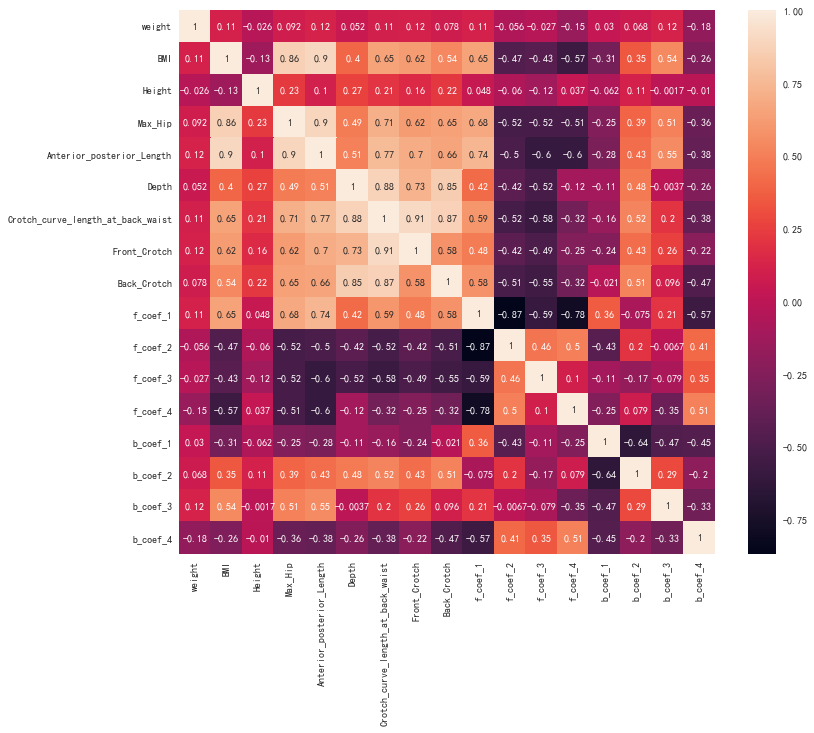

In [14]:
# Correlation heatmap
corr = df2.corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns, yticklabels=corr.columns)

## PCA AND K-Means

In [15]:
df2

,weight,BMI,Height,Max_Hip,Anterior_posterior_Length,Depth,Crotch_curve_length_at_back_waist,Front_Crotch,Back_Crotch,f_coef_1,f_coef_2,f_coef_3,f_coef_4,b_coef_1,b_coef_2,b_coef_3,b_coef_4
0,76.19,21.400000,1601.0,934.0,254.2900,245.0120,662.811,311.565,351.246,137.750,-37.204,-44.023,-56.523,-120.081,107.819,52.613,-40.351
1,74.06,26.000000,1685.0,1097.0,281.7800,234.3100,661.394,307.836,353.558,180.631,-68.187,-57.729,-54.715,-106.661,82.001,55.482,-30.822
2,85.92,32.900000,1644.0,1231.0,348.9300,249.7300,737.270,343.401,393.869,261.676,-80.415,-82.553,-98.708,-102.555,85.451,45.998,-28.894
3,94.30,23.700000,1603.0,1020.0,277.1100,313.6700,811.027,390.940,420.087,192.094,-76.409,-52.685,-63.000,-119.169,115.620,33.099,-29.549
4,78.04,24.100000,1554.0,1034.0,265.9500,267.7900,703.322,336.187,367.135,182.888,-63.174,-61.896,-57.818,-97.988,89.990,57.893,-49.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,77.37,19.309389,1710.0,920.0,238.5356,281.6155,714.102,325.735,388.367,117.353,-33.565,-49.055,-34.734,-135.412,109.641,12.328,13.443
458,79.68,22.761793,1685.0,1020.0,278.1208,216.5177,606.796,288.955,317.841,147.710,-33.202,-53.230,-61.279,-132.966,82.060,46.768,4.138
459,75.14,28.309274,1601.0,1062.0,291.3675,228.6181,651.666,315.466,336.200,199.460,-73.157,-67.685,-58.618,-114.524,77.295,46.068,-8.839
460,80.39,21.376065,1769.0,1004.0,249.2301,211.0781,593.247,265.880,327.367,186.184,-69.034,-40.237,-76.913,-86.283,76.888,37.499,-28.104


In [16]:
# Standardize the data
standard = preprocessing.scale(df2.values)
print(standard)

[[-0.54545592 -0.51668203 -0.78087315 ...  0.50804234  0.54779056
  -0.98278968]
 [-0.84160175  0.5933507   0.36870862 ... -1.01766718  0.75108099
  -0.50506977]
 [ 0.80736047  2.2583998  -0.19239676 ... -0.81379013  0.07906757
  -0.40841283]
 ...
 [-0.6914433   1.15060499 -0.78087315 ... -1.29576731  0.0840276
   0.59700984]
 [ 0.0384936  -0.52245782  1.5182904  ... -1.31981889 -0.52315113
  -0.36880755]
 [ 0.70447413  0.11062208  0.46450711 ...  0.57251476  0.21610615
   1.15604591]]


In [17]:
# Do PCA to reduce dimensional to 2
PCA_x = PCA(n_components = 2).fit_transform(standard)

In [18]:
PCA_r = pd.DataFrame(PCA_x)
PCA_r["Race"] = df["Race"]

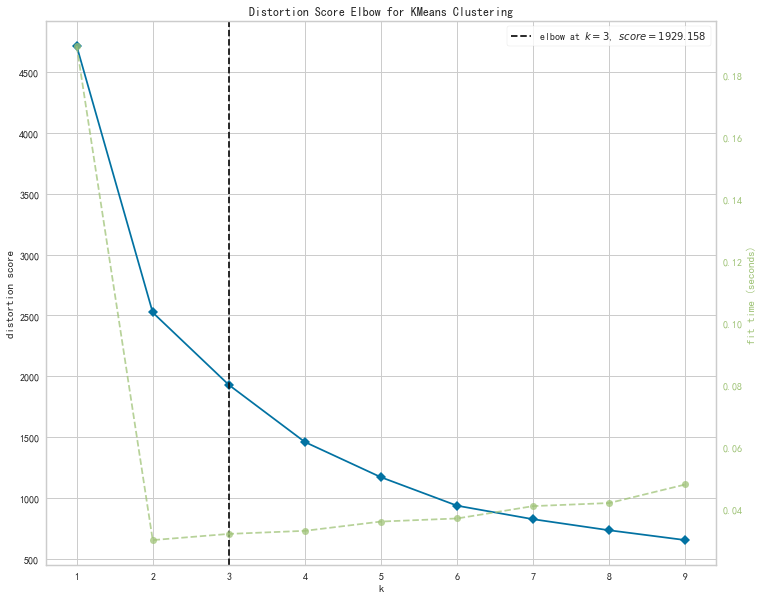

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
# Elbow method to get the optimal value of K for K-means
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(1,10))
 
visualizer.fit(PCA_x)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [20]:
# Do the K-means
clf = KMeans(n_clusters=3, init = "k-means++", max_iter = 100, random_state=0).fit(PCA_x)
clf.cluster_centers_;

In [21]:
df3 = pd.DataFrame(PCA_x)
df3["k_means_labels"] = clf.labels_
df3['Race'] = PCA_r["Race"]
df_1 = df3[df3['k_means_labels'] == 0]
df_2 = df3[df3['k_means_labels'] == 1]
df3;

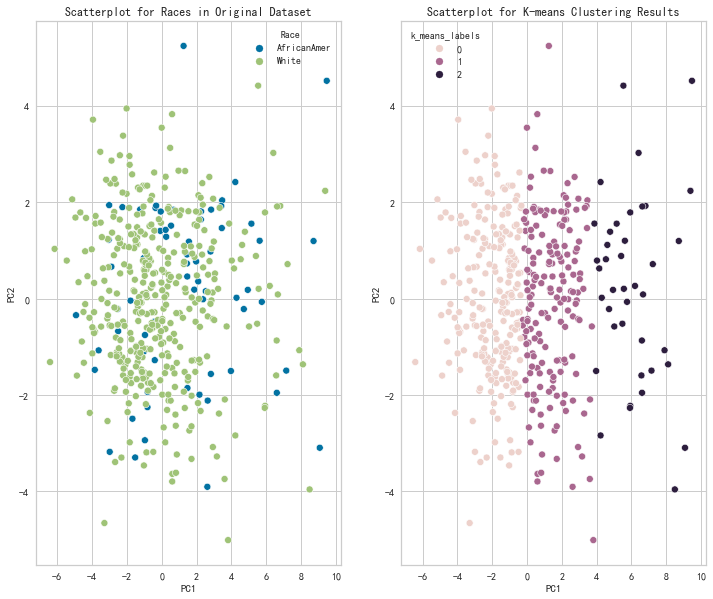

In [22]:
# Visualize the K-means results
fig = plt.figure()
ax1 = plt.subplot(121)
sns.scatterplot(df3[0], df3[1], hue = df3["Race"], ax = ax1)
plt.title("Scatterplot for Races in Original Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")

ax2 = plt.subplot(122)
sns.scatterplot(df3[0], df3[1], hue = df3["k_means_labels"], ax = ax2)
plt.title("Scatterplot for K-means Clustering Results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [23]:
X_clustered = pd.DataFrame(standard, index = df2.index, columns = df2.columns)
X_clustered["cluster"] = clf.labels_

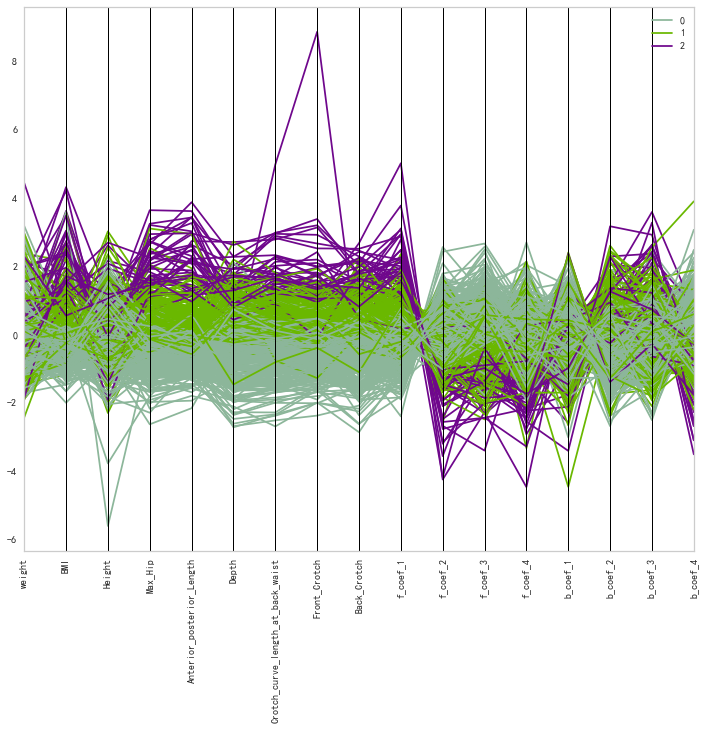

In [24]:
# See the characteristics of each cluster
pd.plotting.parallel_coordinates(X_clustered,"cluster")
plt.xticks(rotation=90)
plt.show()

## Heat Maps

In [25]:
standard_2 = preprocessing.scale(df.iloc[:,[1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]])
standard_2 = pd.DataFrame(standard_2)
standard_2 = standard_2.rename(columns={0:"weight",1:"BMI",2:"Height",3:"Max_Hip",4:"Anterior_posterior_Length",
                                    5:"Depth",6:"Crotch_curve_length_at_back_waist", 7:"Front_Crotch", 8:"Back_Crotch",
                                    9:"f_coef_1", 10:"f_coef_2", 11:"f_coef_3", 12:"f_coef_4", 13:"b_coef_1", 14:"b_coef_2",
                                    15:"b_coef_3", 16:"b_coef_4"})

standard_2;
standard_2['Race'] = df['Race'];
standard_2

,weight,BMI,Height,Max_Hip,Anterior_posterior_Length,Depth,Crotch_curve_length_at_back_waist,Front_Crotch,Back_Crotch,f_coef_1,f_coef_2,f_coef_3,f_coef_4,b_coef_1,b_coef_2,b_coef_3,b_coef_4,Race
0,-0.545456,-0.516682,-0.780873,-1.065765,-0.567946,-0.782420,-0.645947,-0.485051,-0.677536,-0.608244,0.893293,1.251520,-0.407610,0.123647,0.508042,0.547791,-0.982790,AfricanAmer
1,-0.841602,0.593351,0.368709,0.839436,0.206696,-1.227374,-0.666946,-0.576960,-0.611958,0.404799,-0.715365,0.273813,-0.325754,0.630221,-1.017667,0.751081,-0.505070,AfricanAmer
2,0.807360,2.258400,-0.192397,2.405675,2.098918,-0.586262,0.457500,0.299615,0.531430,2.319448,-1.350252,-1.496987,-2.317502,0.785213,-0.813790,0.079068,-0.408413,AfricanAmer
3,1.972479,0.038334,-0.753502,-0.060567,0.075099,2.072152,1.550543,1.471314,1.275082,0.675607,-1.142257,0.633623,-0.700851,0.158073,0.969041,-0.834925,-0.441250,AfricanAmer
4,-0.288240,0.134859,-1.424092,0.103070,-0.239379,0.164613,-0.045593,0.121811,-0.226858,0.458120,-0.455087,-0.023436,-0.466240,0.957607,-0.545559,0.921919,-1.461262,AfricanAmer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,-0.381394,-1.021170,0.710846,-1.229402,-1.011890,0.739432,0.114161,-0.135801,0.375370,-1.090113,1.082233,0.892566,0.578870,-0.455063,0.615713,-2.306708,1.714079,White
458,-0.060222,-0.188066,0.368709,-0.060567,0.103583,-1.967119,-1.476062,-1.042322,-1.625041,-0.372944,1.101080,0.594746,-0.622934,-0.362732,-1.014181,0.133628,1.247589,White
459,-0.691443,1.150605,-0.780873,0.430344,0.476862,-1.464024,-0.811110,-0.388902,-1.104303,0.849625,-0.973411,-0.436390,-0.502459,0.333411,-1.295767,0.084028,0.597010,White
460,0.038494,-0.522458,1.518290,-0.247580,-0.710529,-2.193279,-1.676851,-1.611054,-1.354844,0.535986,-0.759342,1.521591,-1.330751,1.399444,-1.319819,-0.523151,-0.368808,White


In [26]:
row_names = df['Race'].values.tolist()
standard_2.index = row_names
standard_2;

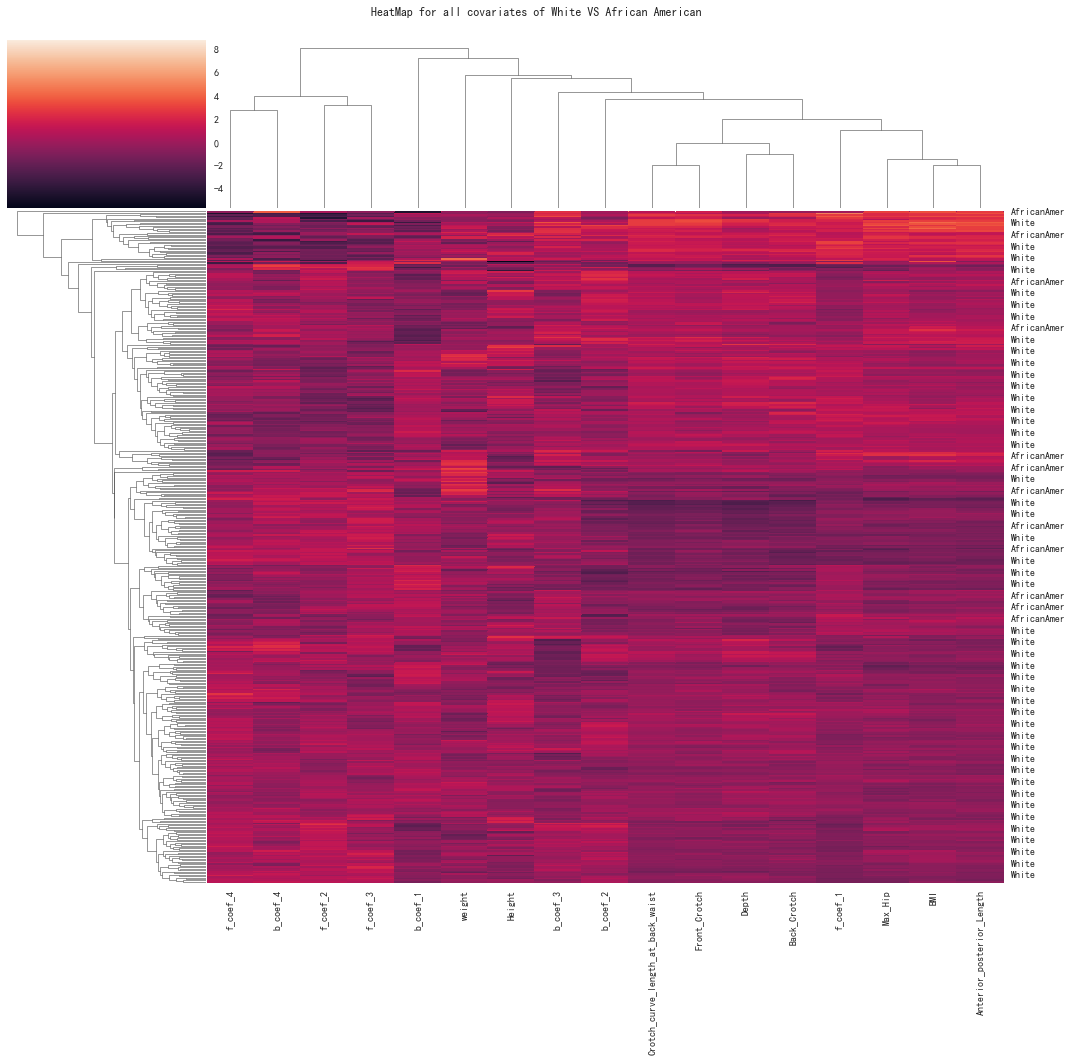

In [27]:
# Do the heatmap
g = sns.clustermap(standard_2.iloc[:,:-1], figsize=(15, 15))
g.fig.suptitle("HeatMap for all covariates of White VS African American") 
g.fig.subplots_adjust(top=0.95)

## Logistics Regression

In [28]:
df['Race_label'] = df['Race'].map({'AfricanAmer':0,'White':1})
df["Race"].value_counts()

White          396
AfricanAmer     66
Name: Race, dtype: int64

In [29]:
X = df.drop(columns = ["Race","Race_label","Subject"], axis=1)
y = df["Race_label"]

In [30]:
# Use SMOTE method to figure out the data imbalanced problem
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [31]:
y_train.value_counts()

1    320
0    313
Name: Race_label, dtype: int64

In [32]:
# Do the logistic regression
logistics = LogisticRegression(random_state = 42).fit(X_train,y_train)
y_pred = logistics.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1], dtype=int64)

In [33]:
Logistic_result = pd.DataFrame(y_test)
Logistic_result = pd.DataFrame(np.concatenate((Logistic_result,pd.DataFrame(y_pred)), axis = 1))
Logistic_result.rename(columns={0:"Original",1:"Predicted"},inplace = True)

In [34]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79        83
           1       0.77      0.76      0.77        76

    accuracy                           0.78       159
   macro avg       0.78      0.78      0.78       159
weighted avg       0.78      0.78      0.78       159



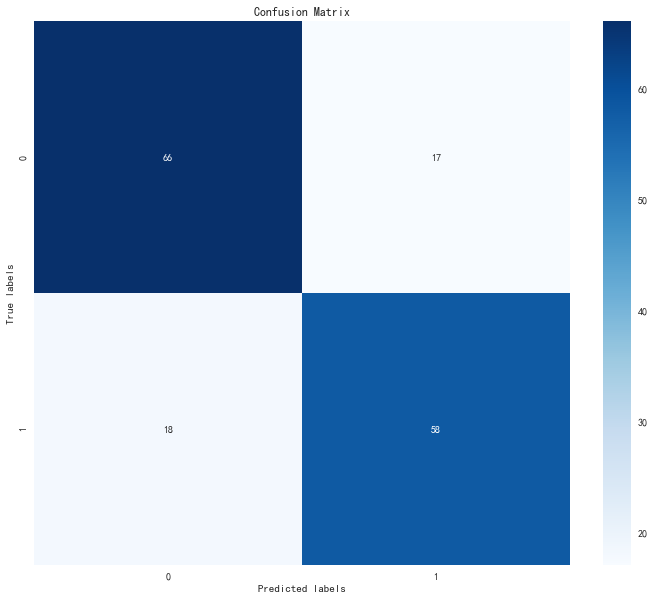

In [35]:
# Create the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

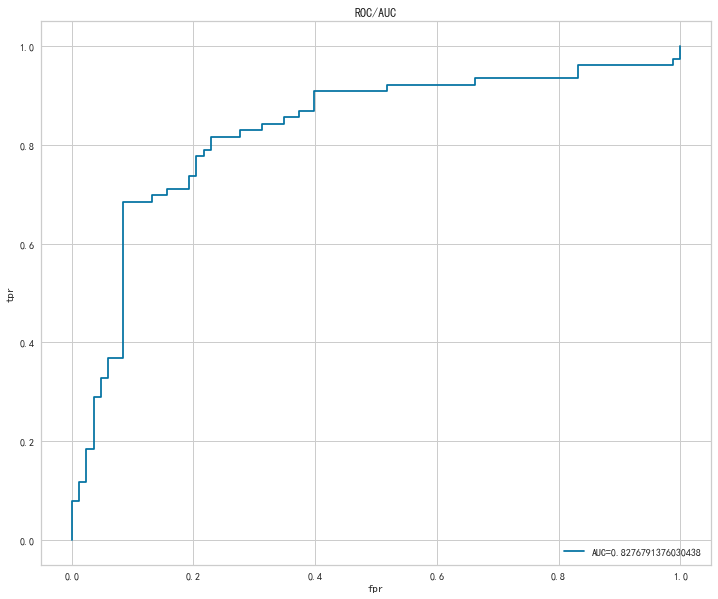

In [36]:
# Display ROC/AUC graph for the logistic regression
y_pred_proba = logistics.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC/AUC')
plt.show() 

In [39]:
thresholds

array([0, 1], dtype=int64)

In [40]:
precision

array([0.47798742, 0.77333333, 1.        ])

In [41]:
recall

array([1.        , 0.76315789, 0.        ])

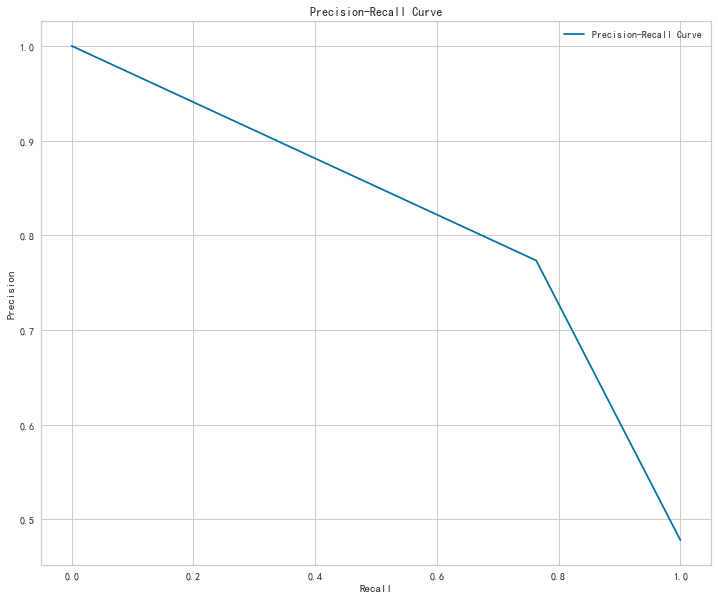

In [38]:
# Display Precison Recall graph for the logistic regression
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label='Precision-Recall Curve')
# set axis labels and legend
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show plot
plt.show()

## Random Forest

In [399]:
# Do the random forest
rf = RandomForestClassifier()
n_estimators = [100, 300, 500, 1000]
max_features = ['auto', 'sqrt']
max_depth = [10, 30, 50]
min_samples_split = [2, 5, 8]
min_samples_leaf = [1, 2 , 3]

In [400]:
# Do cross validation for each combination of hyperparameter
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=5, verbose=3, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 8],
                                        'n_estimators': [100, 300, 500, 1000]},
                   random_state=42, verbose=3)

In [401]:
print('Best hyperparameters:', rf_random.best_params_)
y_pred = rf_random.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50}
Accuracy: 0.8742138364779874


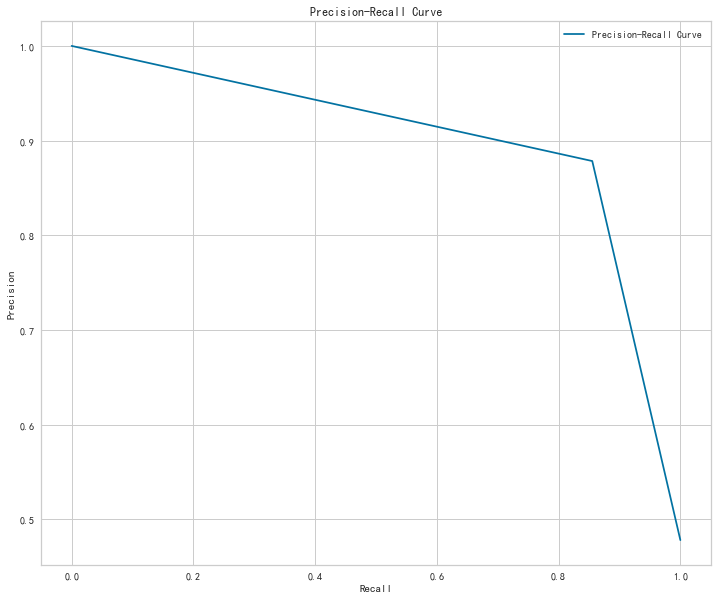

In [402]:
# Display Precison Recall graph for the random forest
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title("Precision-Recall Curve")
# set axis labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show plot
plt.show()

In [403]:
rf_hp = pd.DataFrame(rf_random.best_estimator_.feature_importances_, index = X_train.columns, columns = ["feature_importances"])

In [404]:
# Show the feature importance for random forest fit
rf_hp.sort_values(by = "feature_importances",ascending = False)

,feature_importances
b_coef_3,0.199013
b_coef_4,0.105003
f_coef_4,0.086917
Depth,0.072752
Anterior_posterior_Length,0.058878
BMI,0.051467
Height,0.049448
weight,0.045973
Crotch_curve_length_at_back_waist,0.045769
b_coef_2,0.044281


# XGboost

In [405]:
# Do the XGBoost model
xgb_model = xgb.XGBClassifier()

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 4, 5, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 300, 500, 1000]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print('Best parameters:', grid_search.best_params_)

# Make predictions on the test set with the best model
best_model = grid_search.best_estimator_
preds = best_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}
Accuracy: 0.8742138364779874


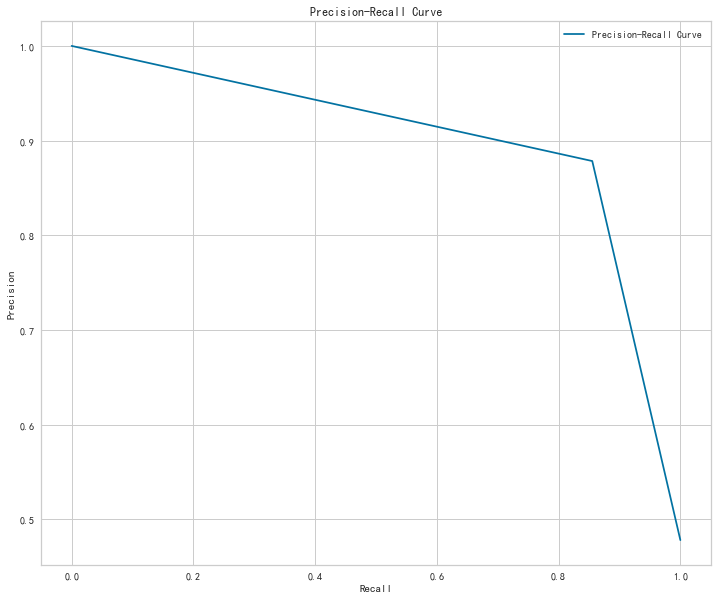

In [406]:
# Display Precison Recall graph for the XGBoost model
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label='Precision-Recall Curve')
# set axis labels and legend
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show plot
plt.show()

In [407]:
xgb_hp = pd.DataFrame(grid_search.best_estimator_.feature_importances_, index = X_train.columns, columns = ["feature_importances"])

In [408]:
# Show the feature importance for the XGBoost fit
xgb_hp.sort_values(by = "feature_importances",ascending = False)

,feature_importances
b_coef_3,0.230318
b_coef_4,0.085182
f_coef_4,0.078491
Depth,0.072858
b_coef_2,0.066037
f_coef_1,0.058607
Height,0.056326
BMI,0.049110
f_coef_3,0.043781
Crotch_curve_length_at_back_waist,0.042259


## Do the same thing for imbalanced data

In [409]:
df['Race_label'] = df['Race'].map({'AfricanAmer':0,'White':1})
df["Race"].value_counts()

White          396
AfricanAmer     66
Name: Race, dtype: int64

In [410]:
X = df.drop(columns = ["Race","Race_label","Subject"], axis=1)
y = df["Race_label"]

In [411]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [412]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [413]:
y_resampled.value_counts()

1    318
0    318
Name: Race_label, dtype: int64

In [414]:
logistics = LogisticRegression(random_state = 42).fit(X_resampled,y_resampled)
y_pred = logistics.predict(X_test)
y_pred

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1], dtype=int64)

In [415]:
Logistic_result = pd.DataFrame(y_test)
Logistic_result = pd.DataFrame(np.concatenate((Logistic_result,pd.DataFrame(y_pred)), axis = 1))
Logistic_result.rename(columns={0:"Original",1:"Predicted"},inplace = True)

In [416]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.34      0.73      0.47        15
           1       0.93      0.73      0.82        78

    accuracy                           0.73        93
   macro avg       0.64      0.73      0.64        93
weighted avg       0.84      0.73      0.76        93



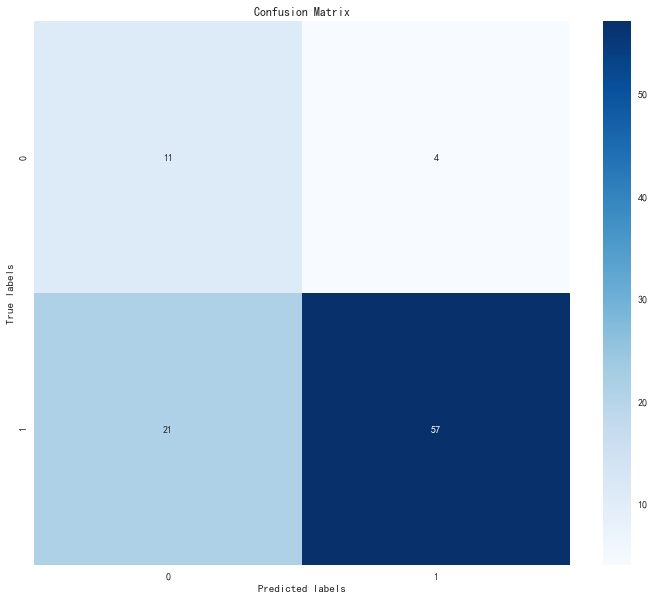

In [417]:
# Create the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

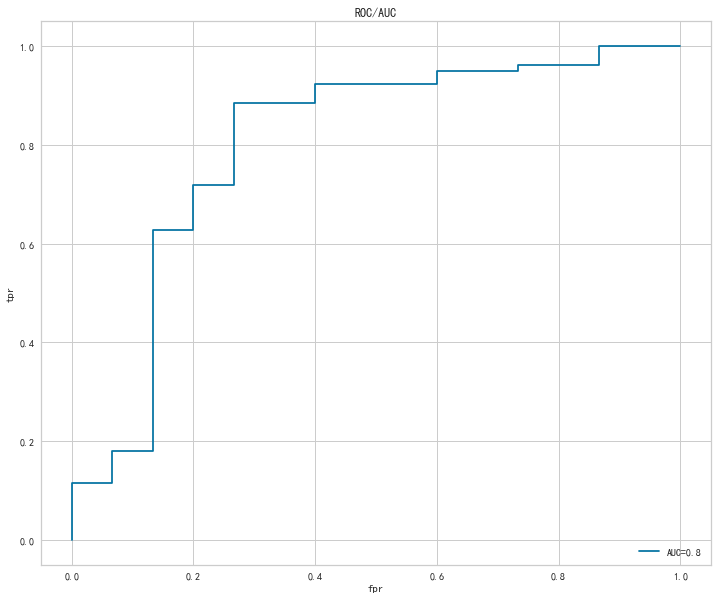

In [418]:
y_pred_proba = logistics.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC/AUC')
plt.show() 

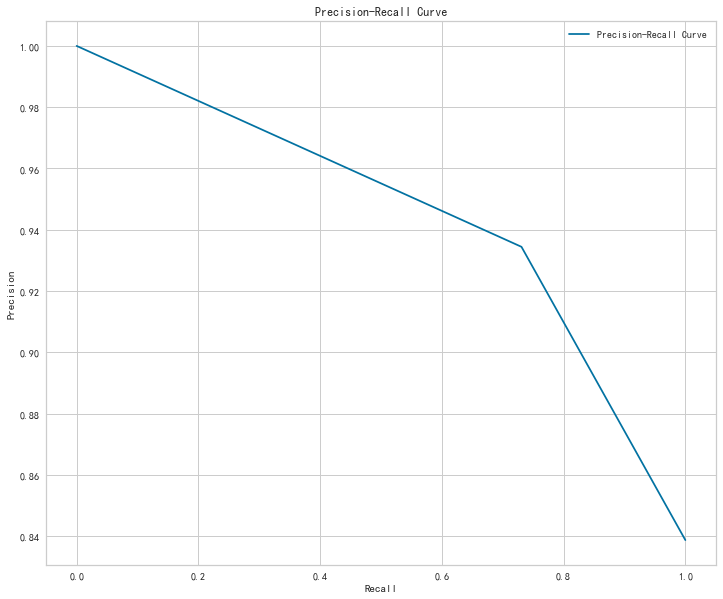

In [420]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label = "Precision-Recall Curve")
# set axis labels and legend
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show plot
plt.show()

## Random Forest

In [421]:
rf = RandomForestClassifier()
n_estimators = [100, 300, 500, 1000]
max_features = ['auto', 'sqrt']
max_depth = [10, 30, 50]
min_samples_split = [2, 5, 8]
min_samples_leaf = [1, 2 , 3]

In [422]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=5, verbose=3, random_state=42, n_jobs=-1)
rf_random.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 8],
                                        'n_estimators': [100, 300, 500, 1000]},
                   random_state=42, verbose=3)

In [423]:
print('Best hyperparameters:', rf_random.best_params_)
y_pred = rf_random.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10}
Accuracy: 0.7741935483870968


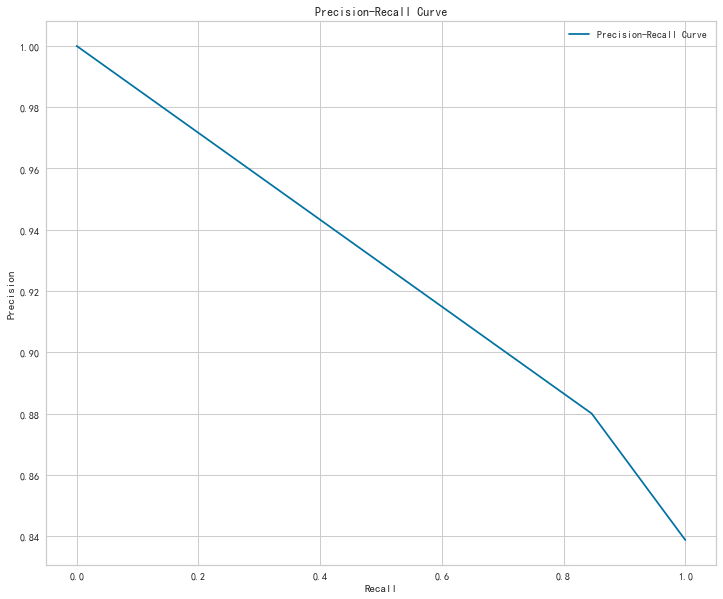

In [424]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label='Precision-Recall Curve')
# set axis labels and legend
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show plot
plt.show()

In [425]:
rf_hp = pd.DataFrame(rf_random.best_estimator_.feature_importances_, index = X_train.columns, columns = ["feature_importances"])

In [426]:
rf_hp.sort_values(by = "feature_importances",ascending = False)

,feature_importances
b_coef_3,0.182649
b_coef_4,0.126609
f_coef_4,0.091740
Depth,0.062353
Anterior_posterior_Length,0.059638
weight,0.054556
b_coef_2,0.046573
BMI,0.044585
Back_Crotch,0.044245
f_coef_1,0.043114


# XGboost

In [427]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier()

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 4, 5, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 300, 500, 1000]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters and score
print('Best parameters:', grid_search.best_params_)

# Make predictions on the test set with the best model
best_model = grid_search.best_estimator_
preds = best_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
Accuracy: 0.7741935483870968


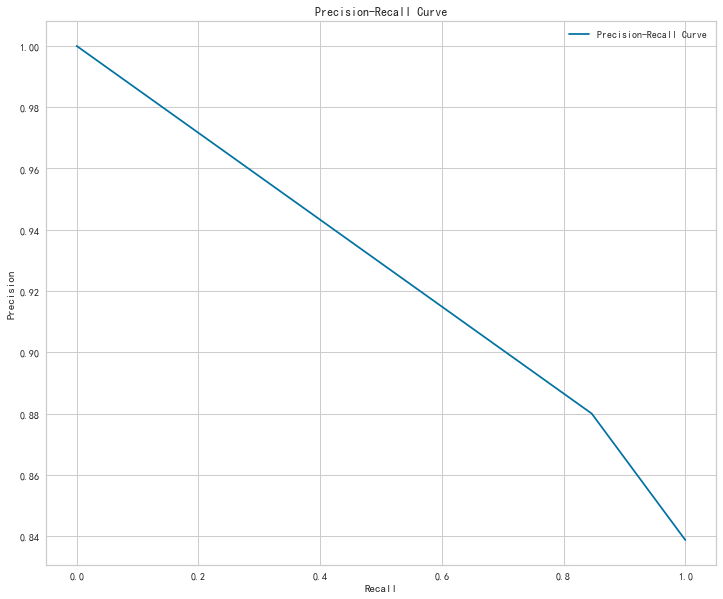

In [428]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label='Precision-Recall Curve')
# set axis labels and legend
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show plot
plt.show()

In [429]:
xgb_hp = pd.DataFrame(grid_search.best_estimator_.feature_importances_, index = X_train.columns, columns = ["feature_importances"])

In [430]:
xgb_hp.sort_values(by = "feature_importances",ascending = False)

,feature_importances
b_coef_3,0.205559
b_coef_4,0.090995
Depth,0.084274
f_coef_4,0.072702
b_coef_2,0.063989
Back_Crotch,0.059975
f_coef_3,0.052599
weight,0.048849
f_coef_1,0.046140
b_coef_1,0.045140


## Do the same thing but use Asian group as the sample set instead of African American

In [431]:
# Load data and see the race value counts
df = pd.read_csv("CombinedWaistDataWithCoordinates with weight.csv")
df_Front = pd.read_csv("CurveCoefficients.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
df_Front.drop('Unnamed: 0', axis=1, inplace=True)
print(df["Race"].value_counts());

White          397
AfricanAmer     66
Asian           56
Other           15
Hispanic         6
Name: Race, dtype: int64


In [432]:
# Merge curve coefficient into the original data through subject ID
df = pd.merge(df, df_Front, on = "Subject",  left_index=True, right_index=True, how='inner')
df.isna().sum();
df = df.dropna();
df.reset_index(drop = True, inplace = True)

In [433]:
cols_x = [col for col in df.columns if col.endswith('_x')]
df = df.loc[:,~df.columns.isin(cols_x)]
df.columns

Index(['Subject', 'weight', 'Curve_Coordinates', 'Race_y', 'BMI_y', 'Height_y',
       'Max_Hip_y', 'Anterior_posterior_Length_y', 'Depth_y',
       'Crotch_curve_length_at_back_waist_y', 'Front_Crotch_y',
       'Back_Crotch_y', 'Curve_Coord_Front', 'Curve_Coord_Back',
       'Coef_Front_2_3', 'intercept_Front_2_3', 'Coef_Back_2_3',
       'intercept_Back_2_3', 'Coef_Front_3_3', 'intercept_Front_3_3',
       'Coef_Back_3_3', 'intercept_Back_3_3', 'Coef_Front_2_4',
       'intercept_Front_2_4', 'Coef_Back_2_4', 'intercept_Back_2_4'],
      dtype='object')

In [434]:
# Create front and back curve coefficient columns.
df["f_coef_1"] = 1
df["f_coef_2"] = 1
df["f_coef_3"] = 1
df["f_coef_4"] = 1
df["b_coef_1"] = 1
df["b_coef_2"] = 1
df["b_coef_3"] = 1
df["b_coef_4"] = 1

In [435]:
# Add front curve coeffcient into the original data set
df["Coef_Front_2_3"];
for x in range(len(df)):
    df["f_coef_1"][x] = df["Coef_Front_2_3"][x].strip("[]").split(",")[0]
    df["f_coef_2"][x] = df["Coef_Front_2_3"][x].strip("[]").split(",")[1]
    df["f_coef_3"][x] = df["Coef_Front_2_3"][x].strip("[]").split(",")[2]
    df["f_coef_4"][x] = df["Coef_Front_2_3"][x].strip("[]").split(",")[3]

df["f_coef_1"] = df["f_coef_1"].astype("float64")
df["f_coef_2"] = df["f_coef_2"].astype("float64")
df["f_coef_3"] = df["f_coef_3"].astype("float64")
df["f_coef_4"] = df["f_coef_4"].astype("float64")
    
df["f_coef_1"] = df["f_coef_1"].apply(lambda x: format(x, '.3f'))
df["f_coef_2"] = df["f_coef_2"].apply(lambda x: format(x, '.3f'))
df["f_coef_3"] = df["f_coef_3"].apply(lambda x: format(x, '.3f'))
df["f_coef_4"] = df["f_coef_4"].apply(lambda x: format(x, '.3f'))

In [436]:
# Add back curve coeffcient into the original data set
df["Coef_Back_2_3"];
for x in range(len(df)):
    df["b_coef_1"][x] = df["Coef_Back_2_3"][x].strip("[]").split(",")[0]
    df["b_coef_2"][x] = df["Coef_Back_2_3"][x].strip("[]").split(",")[1]
    df["b_coef_3"][x] = df["Coef_Back_2_3"][x].strip("[]").split(",")[2]
    df["b_coef_4"][x] = df["Coef_Back_2_3"][x].strip("[]").split(",")[3]

df["b_coef_1"] = df["b_coef_1"].astype("float64")
df["b_coef_2"] = df["b_coef_2"].astype("float64")
df["b_coef_3"] = df["b_coef_3"].astype("float64")
df["b_coef_4"] = df["b_coef_4"].astype("float64")
    
df["b_coef_1"] = df["b_coef_1"].apply(lambda x: format(x, '.3f'))
df["b_coef_2"] = df["b_coef_2"].apply(lambda x: format(x, '.3f'))
df["b_coef_3"] = df["b_coef_3"].apply(lambda x: format(x, '.3f'))
df["b_coef_4"] = df["b_coef_4"].apply(lambda x: format(x, '.3f'))

In [437]:
# Take out the columns we need
df = df.iloc[:,[0,1,3,4,5,6,7,8,9,10,11,26,27,28,29,30,31,32,33]]
df;

In [438]:
# Convert datatype to float
df["Height_y"] = df["Height_y"].astype("float64")
df["Max_Hip_y"] = df["Max_Hip_y"].astype("float64")
df["f_coef_1"] = df["f_coef_1"].astype("float64")
df["f_coef_2"] = df["f_coef_2"].astype("float64")
df["f_coef_3"] = df["f_coef_3"].astype("float64")
df["f_coef_4"] = df["f_coef_4"].astype("float64")
df["b_coef_1"] = df["b_coef_1"].astype("float64")
df["b_coef_2"] = df["b_coef_2"].astype("float64")
df["b_coef_3"] = df["b_coef_3"].astype("float64")
df["b_coef_4"] = df["b_coef_4"].astype("float64")

In [439]:
df.rename(columns = {"BMI_y":"BMI","Height_y":"Height","Max_Hip_y":"Max_Hip","Anterior_posterior_Length_y":"Anterior_posterior_Length",
                     "Depth_y":"Depth","Crotch_curve_length_at_back_waist_y":"Crotch_curve_length_at_back_waist","Front_Crotch_y":"Front_Crotch",
                     "Back_Crotch_y":"Back_Crotch","Race_y":"Race"}, inplace = True)

In [440]:
df = df[(df["Race"]=="Asian") | (df["Race"]=="White")]
df.reset_index(inplace = True, drop = True)
df;

In [441]:
df2 = df.iloc[:,[1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]
df2

,weight,BMI,Height,Max_Hip,Anterior_posterior_Length,Depth,Crotch_curve_length_at_back_waist,Front_Crotch,Back_Crotch,f_coef_1,f_coef_2,f_coef_3,f_coef_4,b_coef_1,b_coef_2,b_coef_3,b_coef_4
0,77.52,22.152364,1647.0,975.0,258.6590,274.1830,698.787,339.931,358.856,135.436,-26.305,-62.438,-46.693,-149.416,118.791,48.229,-17.604
1,80.95,24.217396,1645.0,952.0,286.2070,299.7270,764.515,359.909,404.606,148.927,-23.109,-64.983,-60.834,-141.627,106.885,36.507,-1.765
2,70.63,20.530267,1541.0,967.0,246.1240,252.7480,659.895,303.214,356.681,147.175,-53.143,-56.998,-37.034,-110.090,90.584,47.057,-27.552
3,69.82,21.490804,1669.0,959.0,246.3330,252.9760,661.837,320.887,340.950,117.781,-42.147,-57.269,-18.365,-138.046,105.114,43.078,-10.146
4,77.37,20.205145,1695.0,991.0,245.9600,268.5630,691.548,348.408,343.140,114.585,-48.729,-50.401,-15.455,-158.531,109.078,45.864,3.589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,77.37,19.309389,1710.0,920.0,238.5356,281.6155,714.102,325.735,388.367,117.353,-33.565,-49.055,-34.734,-135.412,109.641,12.328,13.443
446,79.68,22.761793,1685.0,1020.0,278.1208,216.5177,606.796,288.955,317.841,147.710,-33.202,-53.230,-61.279,-132.966,82.060,46.768,4.138
447,75.14,28.309274,1601.0,1062.0,291.3675,228.6181,651.666,315.466,336.200,199.460,-73.157,-67.685,-58.618,-114.524,77.295,46.068,-8.839
448,80.39,21.376065,1769.0,1004.0,249.2301,211.0781,593.247,265.880,327.367,186.184,-69.034,-40.237,-76.913,-86.283,76.888,37.499,-28.104


<AxesSubplot:>

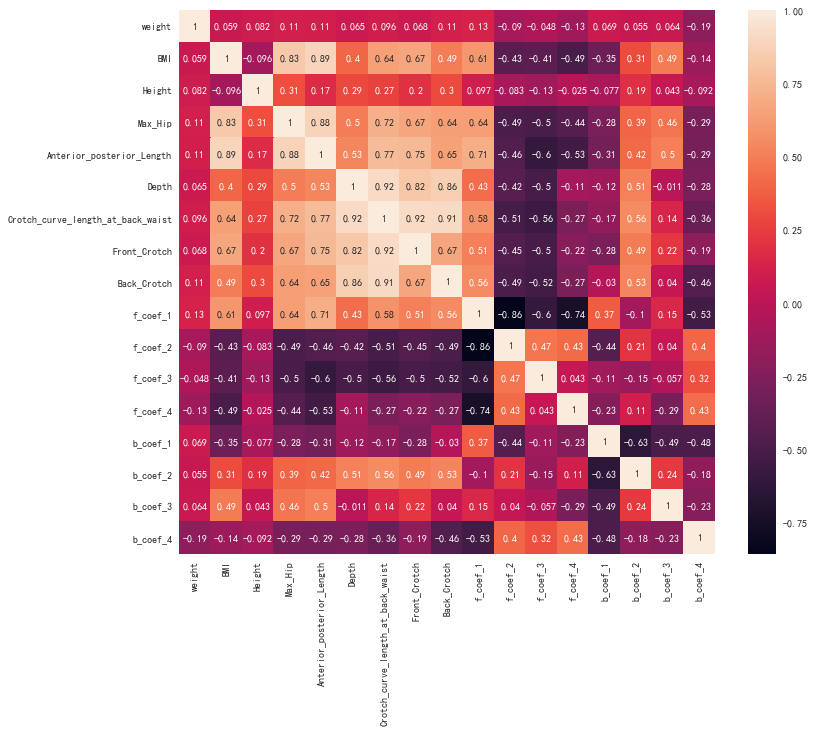

In [442]:
corr = df2.corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns, yticklabels=corr.columns)

## PCA AND K-Means

In [443]:
df2

,weight,BMI,Height,Max_Hip,Anterior_posterior_Length,Depth,Crotch_curve_length_at_back_waist,Front_Crotch,Back_Crotch,f_coef_1,f_coef_2,f_coef_3,f_coef_4,b_coef_1,b_coef_2,b_coef_3,b_coef_4
0,77.52,22.152364,1647.0,975.0,258.6590,274.1830,698.787,339.931,358.856,135.436,-26.305,-62.438,-46.693,-149.416,118.791,48.229,-17.604
1,80.95,24.217396,1645.0,952.0,286.2070,299.7270,764.515,359.909,404.606,148.927,-23.109,-64.983,-60.834,-141.627,106.885,36.507,-1.765
2,70.63,20.530267,1541.0,967.0,246.1240,252.7480,659.895,303.214,356.681,147.175,-53.143,-56.998,-37.034,-110.090,90.584,47.057,-27.552
3,69.82,21.490804,1669.0,959.0,246.3330,252.9760,661.837,320.887,340.950,117.781,-42.147,-57.269,-18.365,-138.046,105.114,43.078,-10.146
4,77.37,20.205145,1695.0,991.0,245.9600,268.5630,691.548,348.408,343.140,114.585,-48.729,-50.401,-15.455,-158.531,109.078,45.864,3.589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,77.37,19.309389,1710.0,920.0,238.5356,281.6155,714.102,325.735,388.367,117.353,-33.565,-49.055,-34.734,-135.412,109.641,12.328,13.443
446,79.68,22.761793,1685.0,1020.0,278.1208,216.5177,606.796,288.955,317.841,147.710,-33.202,-53.230,-61.279,-132.966,82.060,46.768,4.138
447,75.14,28.309274,1601.0,1062.0,291.3675,228.6181,651.666,315.466,336.200,199.460,-73.157,-67.685,-58.618,-114.524,77.295,46.068,-8.839
448,80.39,21.376065,1769.0,1004.0,249.2301,211.0781,593.247,265.880,327.367,186.184,-69.034,-40.237,-76.913,-86.283,76.888,37.499,-28.104


In [444]:
standard = preprocessing.scale(df2.values)
print(standard)

[[-0.2176293  -0.24441482 -0.05772807 ...  1.27195832  0.41947934
  -0.01164865]
 [ 0.28370769  0.30349152 -0.08485876 ...  0.56708316 -0.47757705
   0.83172037]
 [-1.22468816 -0.67479907 -1.49565452 ... -0.39799074  0.32978901
  -0.54134338]
 ...
 [-0.56549579  1.38917247 -0.68173389 ... -1.18474414  0.25410322
   0.45505565]
 [ 0.20185676 -0.45038701  1.59724387 ... -1.20883991 -0.40166168
  -0.57073537]
 [ 0.9019746   0.24569453  0.5527124  ...  0.68696996  0.39675065
   1.04880576]]


In [445]:
PCA_x = PCA(n_components = 2).fit_transform(standard)

In [446]:
PCA_r = pd.DataFrame(PCA_x)
PCA_r["Race"] = df["Race"]

In [447]:
from yellowbrick.cluster import KElbowVisualizer

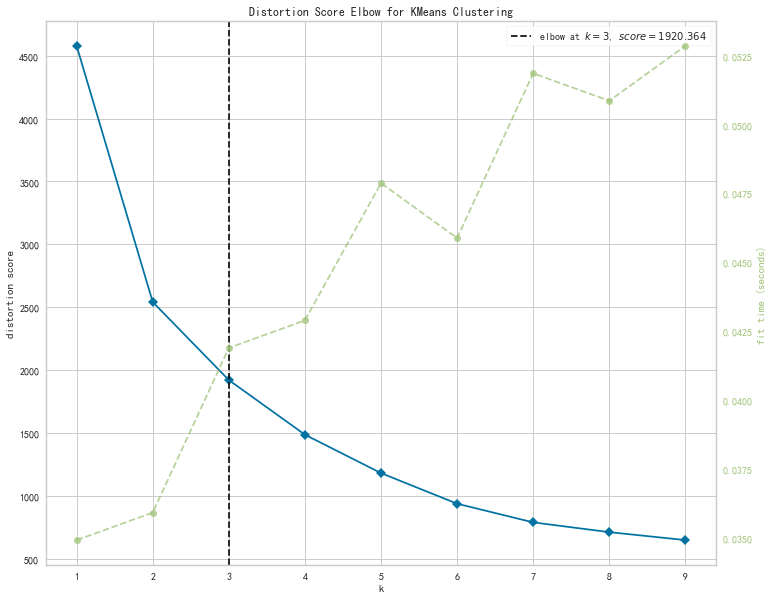

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [448]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(1,10))
 
visualizer.fit(PCA_x)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [449]:
clf = KMeans(n_clusters=3, init = "k-means++", max_iter = 100, random_state=0).fit(PCA_x)
clf.cluster_centers_;

In [450]:
df3 = pd.DataFrame(PCA_x)
df3["k_means_labels"] = clf.labels_
df3['Race'] = PCA_r["Race"]
df_1 = df3[df3['k_means_labels'] == 0]
df_2 = df3[df3['k_means_labels'] == 1]
df3;

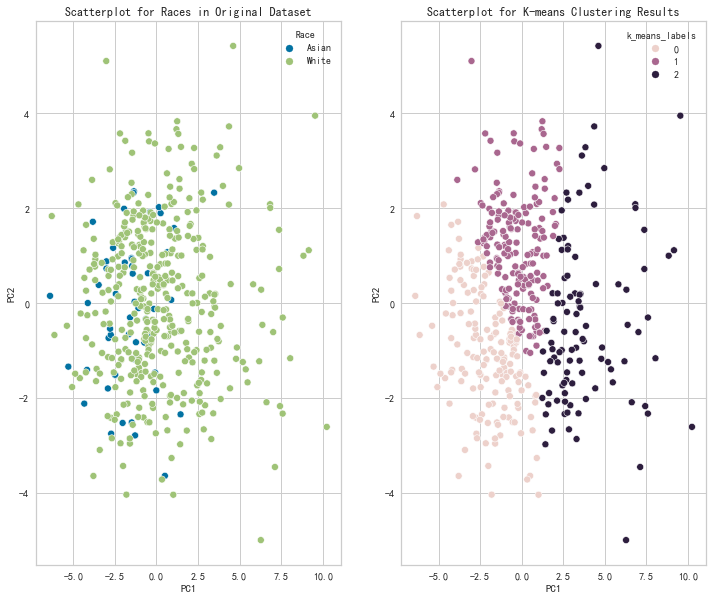

In [451]:
# Visualize the K-means results
fig = plt.figure()
ax1 = plt.subplot(121)
sns.scatterplot(df3[0], df3[1], hue = df3["Race"], ax = ax1)
plt.title("Scatterplot for Races in Original Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")

ax2 = plt.subplot(122)
sns.scatterplot(df3[0], df3[1], hue = df3["k_means_labels"], ax = ax2)
plt.title("Scatterplot for K-means Clustering Results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [452]:
X_clustered = pd.DataFrame(standard, index = df2.index, columns = df2.columns)
X_clustered["cluster"] = clf.labels_

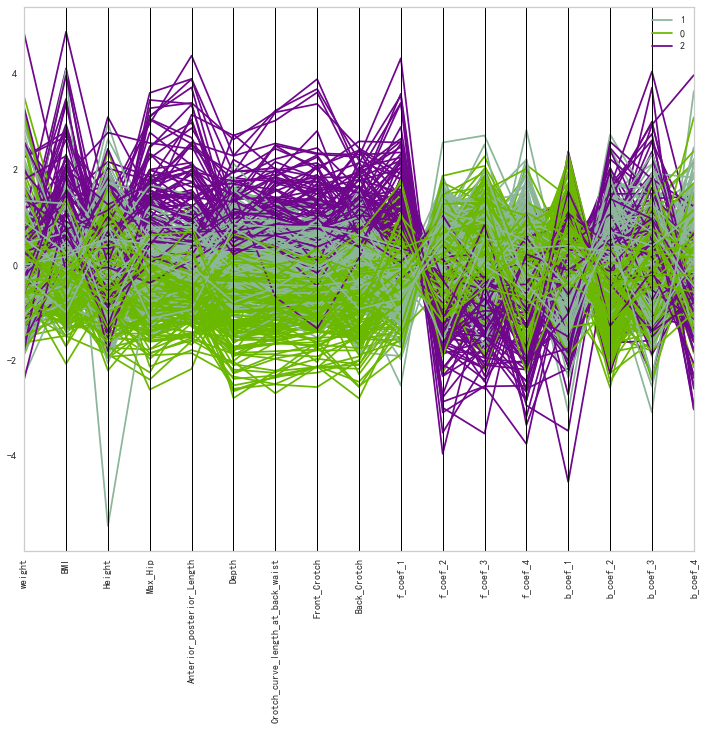

In [453]:
pd.plotting.parallel_coordinates(X_clustered,"cluster")
plt.xticks(rotation=90)
plt.show()

## Heat Maps

In [454]:
df

,Subject,weight,Race,BMI,Height,Max_Hip,Anterior_posterior_Length,Depth,Crotch_curve_length_at_back_waist,Front_Crotch,Back_Crotch,f_coef_1,f_coef_2,f_coef_3,f_coef_4,b_coef_1,b_coef_2,b_coef_3,b_coef_4
0,69,77.52,Asian,22.152364,1647.0,975.0,258.6590,274.1830,698.787,339.931,358.856,135.436,-26.305,-62.438,-46.693,-149.416,118.791,48.229,-17.604
1,70,80.95,Asian,24.217396,1645.0,952.0,286.2070,299.7270,764.515,359.909,404.606,148.927,-23.109,-64.983,-60.834,-141.627,106.885,36.507,-1.765
2,119,70.63,Asian,20.530267,1541.0,967.0,246.1240,252.7480,659.895,303.214,356.681,147.175,-53.143,-56.998,-37.034,-110.090,90.584,47.057,-27.552
3,160,69.82,Asian,21.490804,1669.0,959.0,246.3330,252.9760,661.837,320.887,340.950,117.781,-42.147,-57.269,-18.365,-138.046,105.114,43.078,-10.146
4,183,77.37,Asian,20.205145,1695.0,991.0,245.9600,268.5630,691.548,348.408,343.140,114.585,-48.729,-50.401,-15.455,-158.531,109.078,45.864,3.589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,2979,77.37,White,19.309389,1710.0,920.0,238.5356,281.6155,714.102,325.735,388.367,117.353,-33.565,-49.055,-34.734,-135.412,109.641,12.328,13.443
446,2991,79.68,White,22.761793,1685.0,1020.0,278.1208,216.5177,606.796,288.955,317.841,147.710,-33.202,-53.230,-61.279,-132.966,82.060,46.768,4.138
447,3006,75.14,White,28.309274,1601.0,1062.0,291.3675,228.6181,651.666,315.466,336.200,199.460,-73.157,-67.685,-58.618,-114.524,77.295,46.068,-8.839
448,3007,80.39,White,21.376065,1769.0,1004.0,249.2301,211.0781,593.247,265.880,327.367,186.184,-69.034,-40.237,-76.913,-86.283,76.888,37.499,-28.104


In [455]:
standard_2 = preprocessing.scale(df.iloc[:,[1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]])
standard_2 = pd.DataFrame(standard_2)
standard_2 = standard_2.rename(columns={0:"weight",1:"BMI",2:"Height",3:"Max_Hip",4:"Anterior_posterior_Length",
                                    5:"Depth",6:"Crotch_curve_length_at_back_waist", 7:"Front_Crotch", 8:"Back_Crotch",
                                    9:"f_coef_1", 10:"f_coef_2", 11:"f_coef_3", 12:"f_coef_4", 13:"b_coef_1", 14:"b_coef_2",
                                    15:"b_coef_3", 16:"b_coef_4"})

standard_2;
standard_2['Race'] = df['Race'];
standard_2

,weight,BMI,Height,Max_Hip,Anterior_posterior_Length,Depth,Crotch_curve_length_at_back_waist,Front_Crotch,Back_Crotch,f_coef_1,f_coef_2,f_coef_3,f_coef_4,b_coef_1,b_coef_2,b_coef_3,b_coef_4,Race
0,-0.217629,-0.244415,-0.057728,-0.454968,-0.320991,0.463068,-0.003677,0.334876,-0.356564,-0.606083,1.504701,-0.102477,-0.104629,-1.022459,1.271958,0.419479,-0.011649,Asian
1,0.283708,0.303492,-0.084859,-0.738997,0.522003,1.506109,1.010786,0.885724,0.963014,-0.252727,1.685210,-0.289131,-0.807768,-0.724711,0.567083,-0.477577,0.831720,Asian
2,-1.224688,-0.674799,-1.495655,-0.553761,-0.704573,-0.412189,-0.603946,-0.677514,-0.419298,-0.298615,-0.011099,0.296500,0.375649,0.480846,-0.397991,0.329789,-0.541343,Asian
3,-1.343080,-0.419944,0.240709,-0.652553,-0.698177,-0.402879,-0.573973,-0.190220,-0.873031,-1.068502,0.609951,0.276624,1.303935,-0.587821,0.462234,0.025286,0.385463,Asian
4,-0.239554,-0.761062,0.593408,-0.257382,-0.709591,0.233586,-0.115406,0.568610,-0.809864,-1.152211,0.238202,0.780333,1.448630,-1.370896,0.696916,0.238492,1.116801,Asian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,-0.239554,-0.998730,0.796889,-1.134168,-0.936784,0.766560,0.232699,-0.056548,0.494629,-1.079712,1.094659,0.879050,0.490013,-0.487132,0.730248,-2.327938,1.641491,White
446,0.098081,-0.082718,0.457755,0.100741,0.274558,-1.891584,-1.423490,-1.070674,-1.539569,-0.284602,1.115161,0.572850,-0.829894,-0.393629,-0.902640,0.307673,1.146034,White
447,-0.565496,1.389172,-0.681734,0.619403,0.679918,-1.397487,-0.730955,-0.339692,-1.010036,1.070832,-1.141482,-0.487299,-0.697581,0.311349,-1.184744,0.254103,0.455056,White
448,0.201857,-0.450387,1.597244,-0.096844,-0.609523,-2.113699,-1.632609,-1.706916,-1.264808,0.723107,-0.908617,1.525774,-1.607270,1.390911,-1.208840,-0.401662,-0.570735,White


In [456]:
row_names = df['Race'].values.tolist()
standard_2.index = row_names
standard_2;

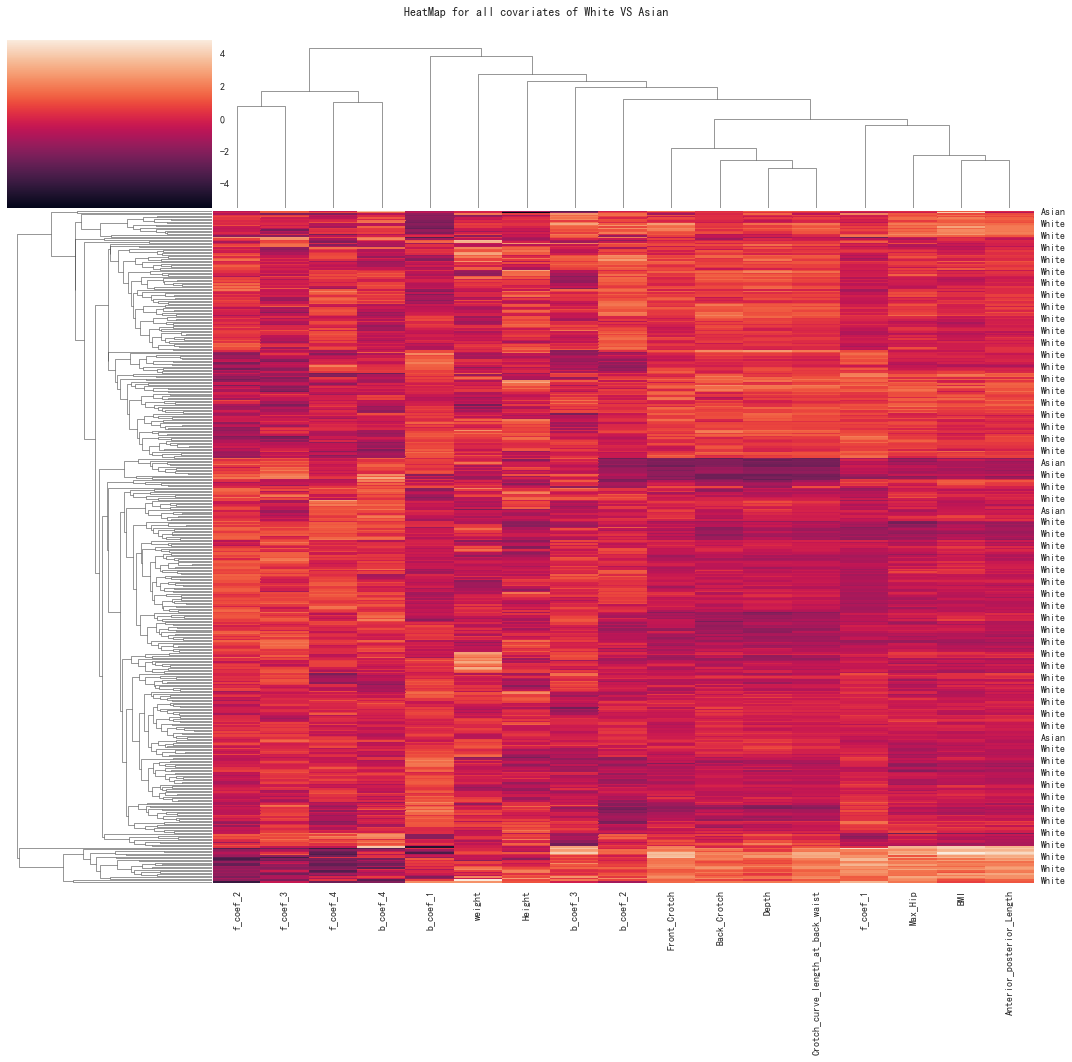

In [457]:
# Do the heatmap
g = sns.clustermap(standard_2.iloc[:,:-1], figsize=(15, 15))
g.fig.suptitle("HeatMap for all covariates of White VS Asian") 
g.fig.subplots_adjust(top=0.95)

## Logistics Regression

In [458]:
df['Race_label'] = df['Race'].map({'Asian':0,'White':1})
df["Race"].value_counts()

White    396
Asian     54
Name: Race, dtype: int64

In [459]:
X = df.drop(columns = ["Race","Race_label","Subject"], axis=1)
y = df["Race_label"]

In [460]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [461]:
y_train.value_counts()

1    320
0    313
Name: Race_label, dtype: int64

In [462]:
logistics = LogisticRegression(random_state = 42).fit(X_train,y_train)
y_pred = logistics.predict(X_test)
y_pred

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1], dtype=int64)

In [463]:
Logistic_result = pd.DataFrame(y_test)
Logistic_result = pd.DataFrame(np.concatenate((Logistic_result,pd.DataFrame(y_pred)), axis = 1))
Logistic_result.rename(columns={0:"Original",1:"Predicted"},inplace = True)

In [464]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65        83
           1       0.63      0.80      0.71        76

    accuracy                           0.68       159
   macro avg       0.69      0.68      0.68       159
weighted avg       0.70      0.68      0.68       159



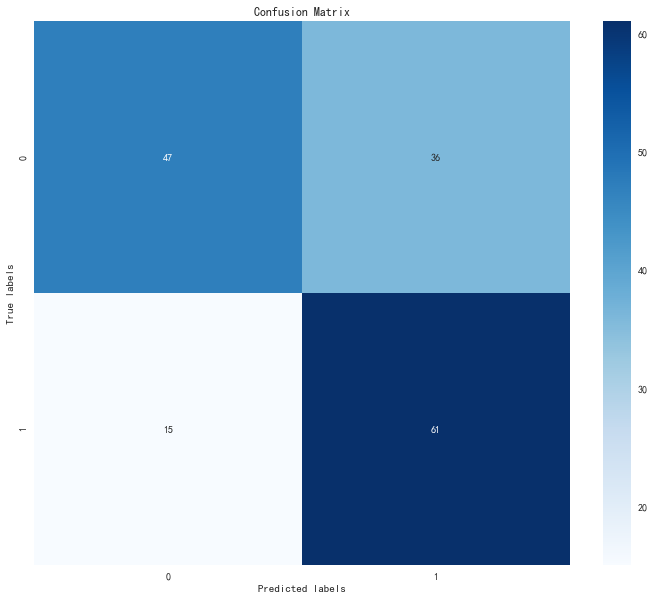

In [465]:
# Create the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

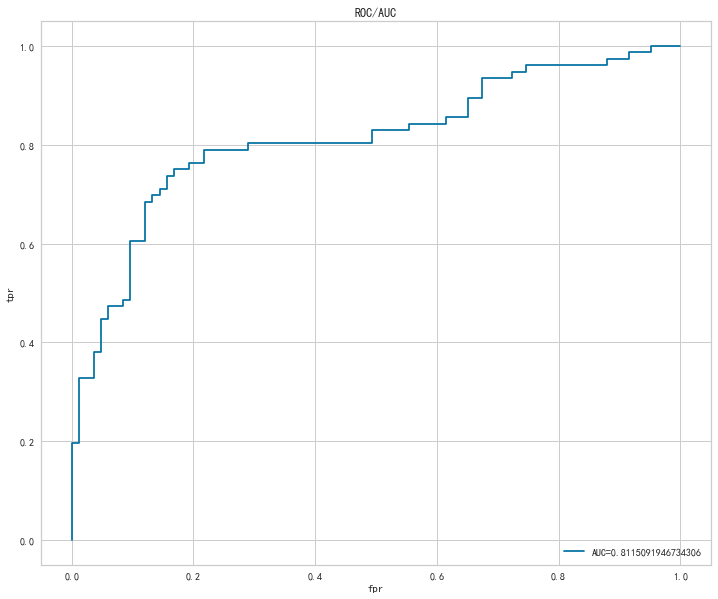

In [466]:
y_pred_proba = logistics.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC/AUC')
plt.show() 

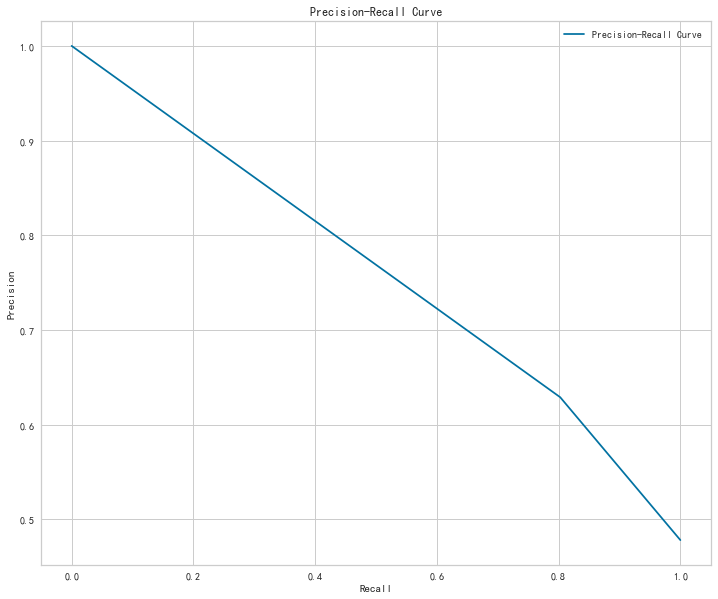

In [467]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label = "Precision-Recall Curve")
# set axis labels and legend
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show plot
plt.show()

## Random Forest

In [468]:
rf = RandomForestClassifier()
n_estimators = [100, 300, 500, 1000]
max_features = ['auto', 'sqrt']
max_depth = [10, 30, 50]
min_samples_split = [2, 5, 8]
min_samples_leaf = [1, 2 , 3]

In [469]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=5, verbose=3, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 8],
                                        'n_estimators': [100, 300, 500, 1000]},
                   random_state=42, verbose=3)

In [470]:
print('Best hyperparameters:', rf_random.best_params_)
y_pred = rf_random.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50}
Accuracy: 0.9371069182389937


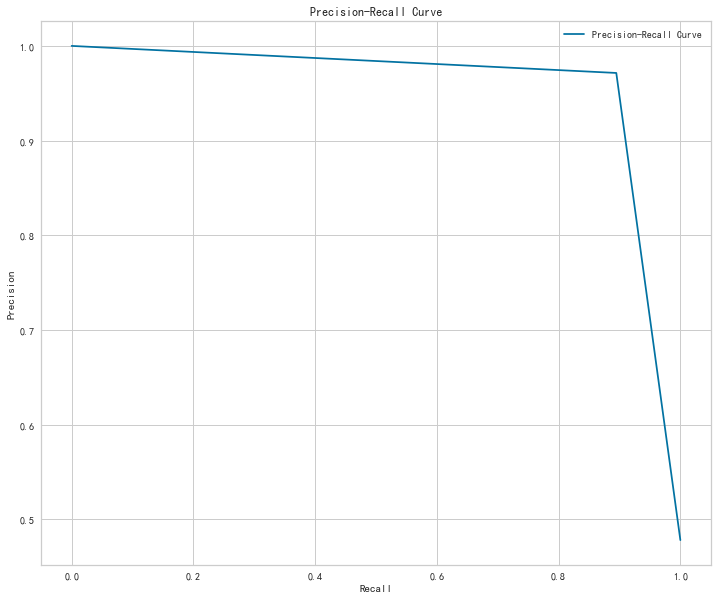

In [471]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label='Precision-Recall Curve')
# set axis labels and legend
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show plot
plt.show()

In [472]:
rf_hp = pd.DataFrame(rf_random.best_estimator_.feature_importances_, index = X_train.columns, columns = ["feature_importances"])

In [473]:
rf_hp.sort_values(by = "feature_importances",ascending = False)

,feature_importances
Height,0.236871
weight,0.113559
Back_Crotch,0.095086
Max_Hip,0.088442
b_coef_4,0.050609
Crotch_curve_length_at_back_waist,0.045086
Anterior_posterior_Length,0.044442
Depth,0.044111
BMI,0.039959
f_coef_1,0.034731


# XGboost

In [474]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier()

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 4, 5, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 300, 500, 1000]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print('Best parameters:', grid_search.best_params_)

# Make predictions on the test set with the best model
best_model = grid_search.best_estimator_
preds = best_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
Accuracy: 0.9371069182389937


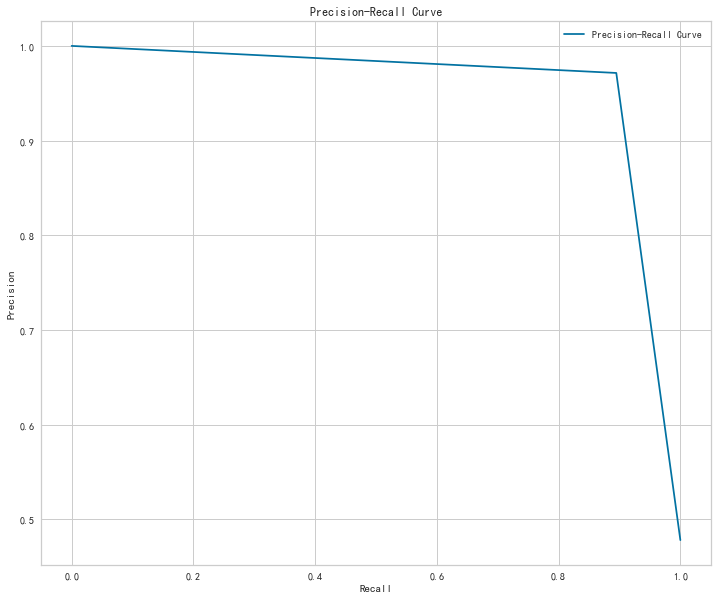

In [475]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label ="Precision-Recall Curve")
# set axis labels and legend
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show plot
plt.show()

In [476]:
xgb_hp = pd.DataFrame(grid_search.best_estimator_.feature_importances_, index = X_train.columns, columns = ["feature_importances"])

In [477]:
xgb_hp.sort_values(by = "feature_importances",ascending = False)

,feature_importances
Height,0.204005
Crotch_curve_length_at_back_waist,0.124223
weight,0.107133
Max_Hip,0.074195
Back_Crotch,0.061916
f_coef_1,0.060594
b_coef_4,0.057069
BMI,0.050234
Depth,0.046393
Anterior_posterior_Length,0.038538


## Do the same thing for imbalanced data

# Logistic Regression

In [478]:
df['Race_label'] = df['Race'].map({'Asian':0,'White':1})
df["Race"].value_counts()

White    396
Asian     54
Name: Race, dtype: int64

In [479]:
X = df.drop(columns = ["Race","Race_label","Subject"], axis=1)
y = df["Race_label"]

In [480]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [481]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [482]:
y_resampled.value_counts()

1    318
0    318
Name: Race_label, dtype: int64

In [483]:
logistics = LogisticRegression(random_state = 42).fit(X_resampled, y_resampled)
y_pred = logistics.predict(X_test)
y_pred

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0], dtype=int64)

In [484]:
Logistic_result = pd.DataFrame(y_test)
Logistic_result = pd.DataFrame(np.concatenate((Logistic_result,pd.DataFrame(y_pred)), axis = 1))
Logistic_result.rename(columns={0:"Original",1:"Predicted"},inplace = True)

In [485]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.16      0.42      0.23        12
           1       0.88      0.65      0.75        78

    accuracy                           0.62        90
   macro avg       0.52      0.54      0.49        90
weighted avg       0.78      0.62      0.68        90



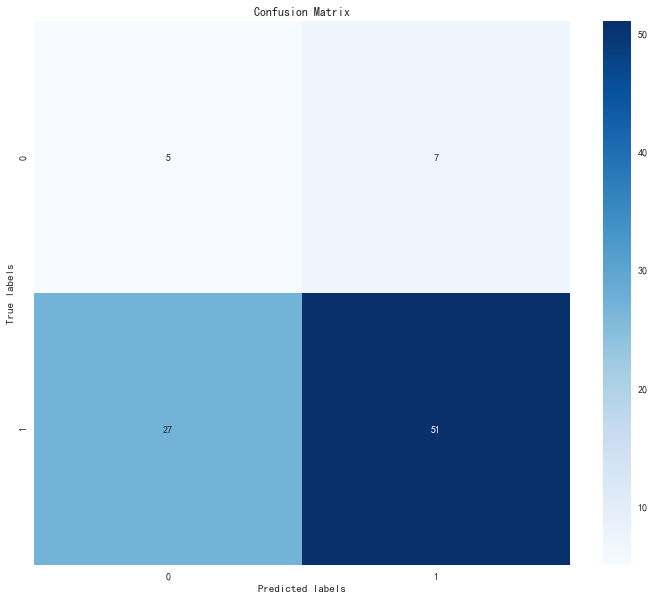

In [486]:
# Create the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

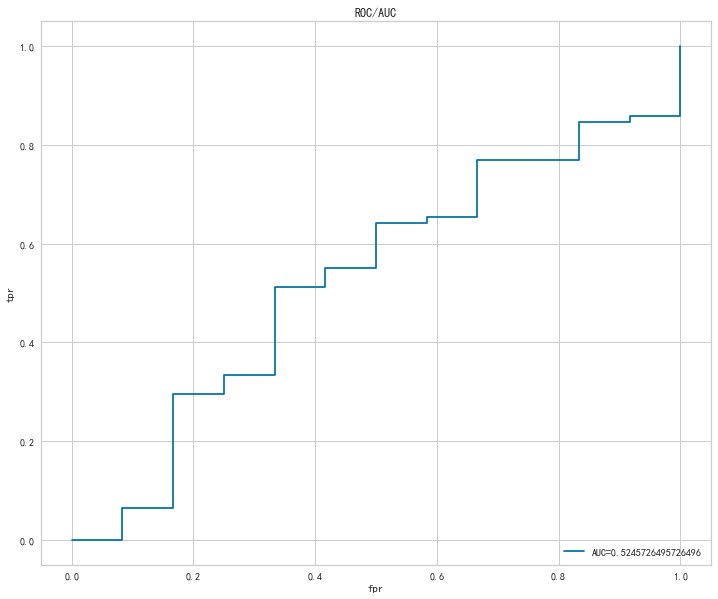

In [487]:
y_pred_proba = logistics.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC/AUC')
plt.show() 

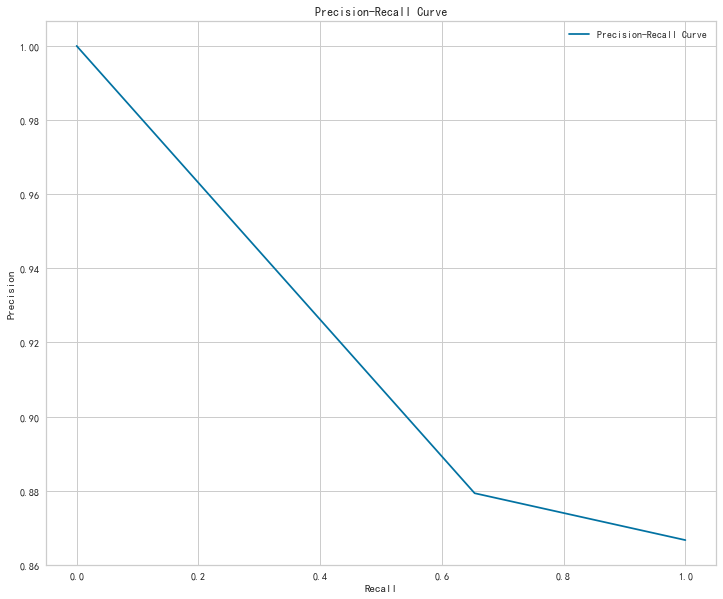

In [488]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label = "Precision-Recall Curve")
# set axis labels and legend
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show plot
plt.show()

## Random Forest

In [489]:
rf = RandomForestClassifier()
n_estimators = [100, 300, 500, 1000]
max_features = ['auto', 'sqrt']
max_depth = [10, 30, 50]
min_samples_split = [2, 5, 8]
min_samples_leaf = [1, 2 , 3]

In [490]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=5, verbose=3, random_state=42, n_jobs=-1)
rf_random.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 8],
                                        'n_estimators': [100, 300, 500, 1000]},
                   random_state=42, verbose=3)

In [491]:
print('Best hyperparameters:', rf_random.best_params_)
y_pred = rf_random.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best hyperparameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50}
Accuracy: 0.8444444444444444


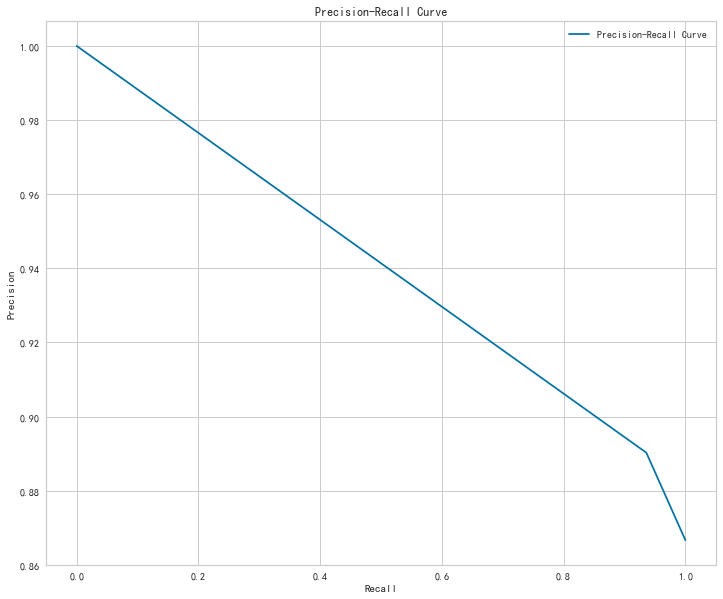

In [492]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label = "Precision-Recall Curve")
# set axis labels and legend
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show plot
plt.show()

In [493]:
rf_hp = pd.DataFrame(rf_random.best_estimator_.feature_importances_, index = X_train.columns, columns = ["feature_importances"])

In [494]:
rf_hp.sort_values(by = "feature_importances",ascending = False)

,feature_importances
Height,0.244045
weight,0.142684
Max_Hip,0.114930
Back_Crotch,0.066185
b_coef_4,0.061560
f_coef_2,0.038607
Crotch_curve_length_at_back_waist,0.038080
BMI,0.036382
Anterior_posterior_Length,0.032881
Front_Crotch,0.032766


# XGboost

In [495]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier()

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 4, 5, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 300, 500, 1000]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters and score
print('Best parameters:', grid_search.best_params_)

# Make predictions on the test set with the best model
best_model = grid_search.best_estimator_
preds = best_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
Accuracy: 0.8444444444444444


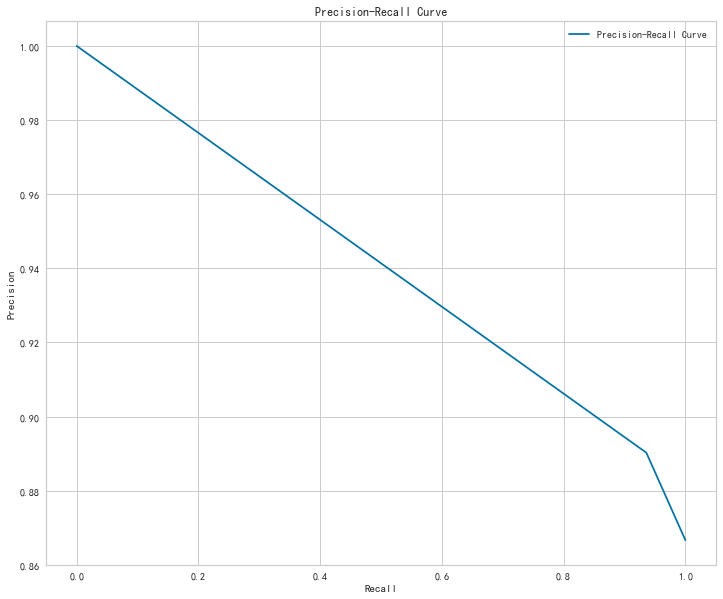

In [496]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label='Precision-Recall Curve')
# set axis labels and legend
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show plot
plt.show()

In [497]:
xgb_hp = pd.DataFrame(grid_search.best_estimator_.feature_importances_, index = X_train.columns, columns = ["feature_importances"])

In [498]:
xgb_hp.sort_values(by = "feature_importances",ascending = False)

,feature_importances
Height,0.263086
weight,0.138149
f_coef_1,0.084276
Back_Crotch,0.064503
Max_Hip,0.062201
b_coef_4,0.052268
b_coef_3,0.044046
Depth,0.037384
f_coef_2,0.034485
Crotch_curve_length_at_back_waist,0.032932
